In [1]:
import os
import sys
import pandas as pd
import numpy as np
import glob
import time
import gget
import scipy
from scipy.sparse import csr_matrix
from scipy.interpolate import make_interp_spline
import anndata as an
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from importlib import reload
import ot

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler

# local imports
source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import centrality as central
import matrix
import utils as ut
import plotting as plt2

In [2]:
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/anndata/population_mESC_1000000_features.h5ad"
start_time = time.time()  # Record the start time
adata = sc.read_h5ad(fpath)
end_time = time.time()  # Record the end time
print(f"Time taken to read the file: {end_time - start_time:.2f} seconds")
sc.logging.print_memory_usage()
adata

Time taken to read the file: 30.38 seconds
Memory usage: current 1.49 GB, difference +1.49 GB


AnnData object with n_obs × n_vars = 2579 × 2756467
    obs: 'bin_index', 'chrom', 'bin_start', 'bin_end', 'bin', 'chrom_bin', 'n_reads', 'n_genes', 'n_tfs', 'n_pt_genes', 'total_gene_bp', 'genes', 'total_len_bp', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp'
    uns: 'base_resolution', 'chrom_sizes', 'genes', 'intervals'
    layers: 'H'

In [3]:
adata.var['higher_order'] = adata.var['order'] > 2
adata.var['higher_order'].value_counts(normalize=True)

higher_order
True     0.80905
False    0.19095
Name: proportion, dtype: float64

In [4]:
adata.layers['H_binary'] = (adata.layers['H'] > 0).astype(int)
adata.X = adata.layers['H_binary'].copy()
adata

AnnData object with n_obs × n_vars = 2579 × 2756467
    obs: 'bin_index', 'chrom', 'bin_start', 'bin_end', 'bin', 'chrom_bin', 'n_reads', 'n_genes', 'n_tfs', 'n_pt_genes', 'total_gene_bp', 'genes', 'total_len_bp', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'higher_order'
    uns: 'base_resolution', 'chrom_sizes', 'genes', 'intervals'
    layers: 'H', 'H_binary'

# Extract Single Chromosome

In [5]:
chromosome = "2"
mask = (adata.obs['chrom'] == chromosome)

cdata = adata[mask,]
cdata = cdata[:, cdata.X.sum(axis=0) > 1]

# recompute the order
order_threshold = 2
cdata.var['chrom_order'] = np.ravel(cdata.X.sum(axis=0))
cdata = cdata[:, cdata.var['chrom_order'] > order_threshold]

# recompute the reads
cdata.obs['degree'] = np.ravel(cdata.X.sum(axis=1))

cdata

AnnData object with n_obs × n_vars = 179 × 51553
    obs: 'bin_index', 'chrom', 'bin_start', 'bin_end', 'bin', 'chrom_bin', 'n_reads', 'n_genes', 'n_tfs', 'n_pt_genes', 'total_gene_bp', 'genes', 'total_len_bp', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'degree'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'higher_order', 'chrom_order'
    uns: 'base_resolution', 'chrom_sizes', 'genes', 'intervals'
    layers: 'H', 'H_binary'

# A bit of QC

In [6]:
def find_outliers_iqr(df_column):
  """
  Identifies outliers in a pandas DataFrame column using the IQR method.

  Args:
    df_column: A pandas Series representing the column to analyze.

  Returns:
    A boolean mask with True for outliers and False otherwise.
  """
  Q1 = df_column.quantile(0.25)
  Q3 = df_column.quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  return (df_column < lower_bound) | (df_column > upper_bound)


cdata.obs['degree_outlier'] = find_outliers_iqr(cdata.obs['degree'])
cdata.obs[['chrom_bin', 'degree', 'degree_outlier']].sort_values(by='degree', ascending=False).head()

,chrom_bin,degree,degree_outlier
bin_name,,,
chr2:98,98,21363,True
chr2:177,177,1664,True
chr2:174,174,1280,True
chr2:176,176,1149,False
chr2:77,77,1089,False


# Drop the outlier indices

In [7]:
cdata = cdata[~cdata.obs['degree_outlier'], : ].copy()
cdata

AnnData object with n_obs × n_vars = 174 × 51553
    obs: 'bin_index', 'chrom', 'bin_start', 'bin_end', 'bin', 'chrom_bin', 'n_reads', 'n_genes', 'n_tfs', 'n_pt_genes', 'total_gene_bp', 'genes', 'total_len_bp', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'degree', 'degree_outlier'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'higher_order', 'chrom_order'
    uns: 'base_resolution', 'chrom_sizes', 'genes', 'intervals'
    layers: 'H', 'H_binary'

# Plot Degree and Order

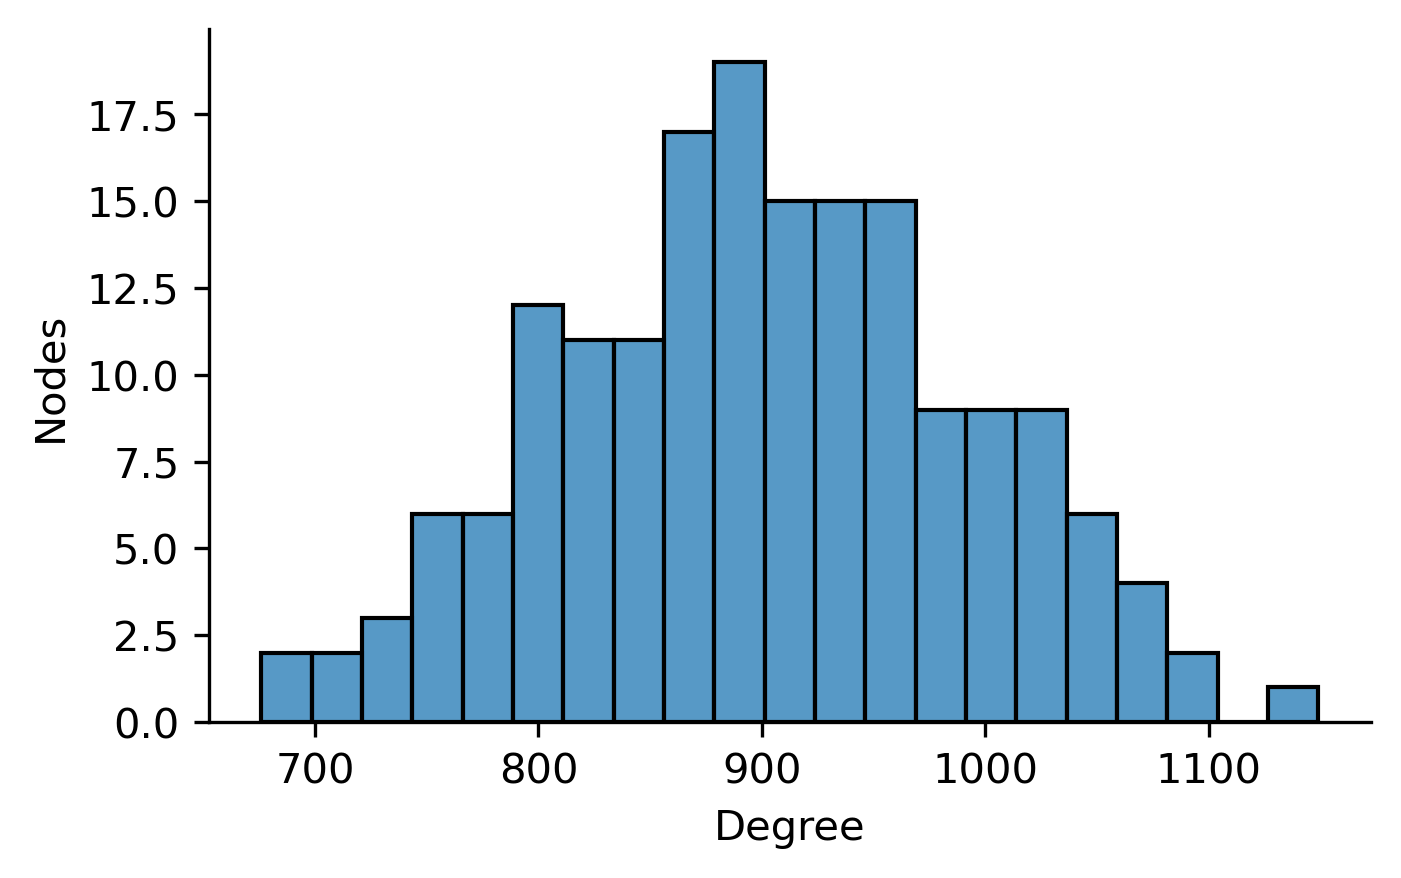

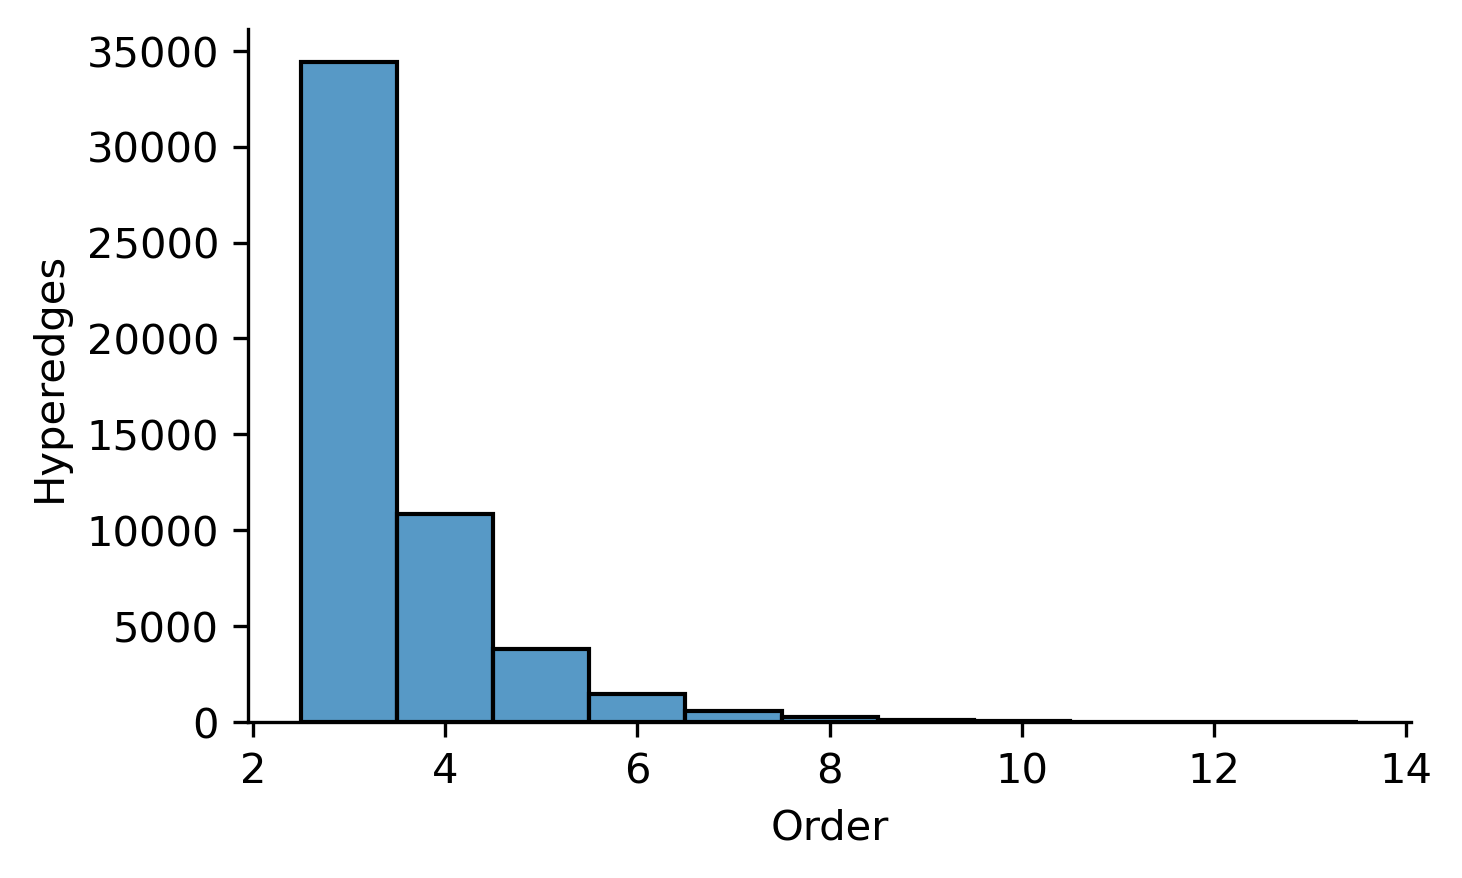

In [8]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 3

sns.histplot(
    data=cdata.obs,
    x='degree',
    bins=21,
)
plt.xlabel('Degree')
plt.ylabel('Nodes')
sns.despine()
plt.show()

sns.histplot(
    data=cdata.var,
    x='chrom_order',
    discrete=True,
)

plt.xlabel('Order')
plt.ylabel('Hyperedges')
sns.despine()
plt.show()

# Plot incidence matrix

In [9]:
H = cdata.to_df()
H.index = cdata.obs['chrom_bin'].values
H = H.sort_index()
print(f"{H.shape=}")
H.head()

H.shape=(174, 51553)


read_name,00453882-8a7e-4244-b889-c4e8b0ab1964,00603079-8253-4793-a0a7-65a646736b2e,00d159c4-7f2b-4e51-a46d-1e22870e0dd3,00d7e061-4df7-4fb5-a10a-2fd47d38bf8e,00dd9bd2-84da-4e7d-a9c7-ecb5d5ad962f,025aa690-2164-453c-be21-06a9d21fe55a,028db687-f9fa-4e00-9a45-c1639daebb27,02b93123-2353-4157-86c6-993cb4d10f98,040e114f-a099-41d5-8d2a-3298adbd172c,05d86f90-1345-4306-943d-fc7254c56803,...,ffcf0b86-b710-4510-a1b7-9bc9d7ceb64b,ffd48967-a1b7-472c-9054-59326fc17846,ffdd6e3b-1d14-422d-aa1f-e2302c343384,ffdf92b8-8061-4b6d-b5be-80d51f358d4e,ffe27831-b4fe-4f5b-8499-486cce955680,ffe6fb7b-0d8a-4fb3-af3a-3504c18fdfa4,ffea8e61-05d4-4d49-bc4f-4ecafdaee708,fffbb892-66d2-4ee6-bdeb-f7d854d75b35,fffc84e9-9d73-470e-85c4-679049a68baf,fffef91a-27b8-466a-a913-61292d2d5efe
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


([], [])

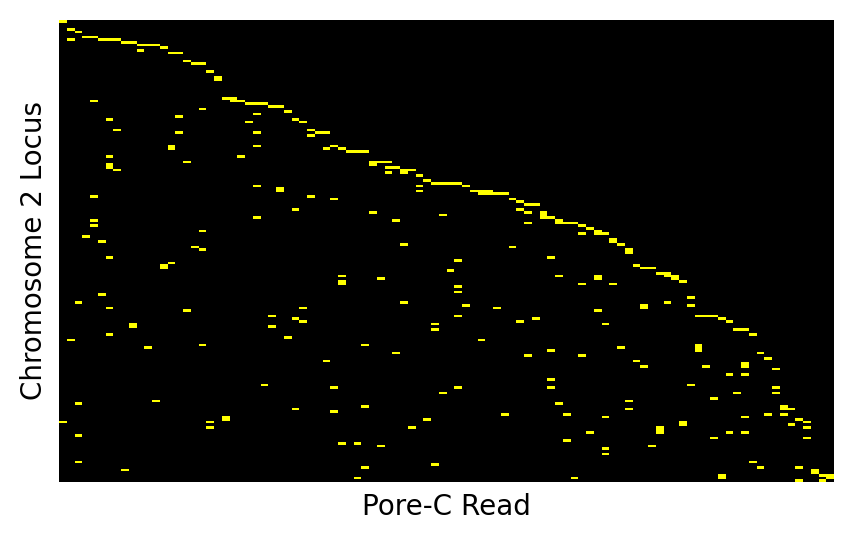

In [10]:
sample_size = 100
pdf = ut.sort_by_lowest_index(H.T.sample(sample_size).T) # sample and sort

# Calculate row and column sums
row_sums = pdf.sum(axis=1)
col_sums = pdf.sum(axis=0)

# Create the heatmap
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 3

sns.heatmap(
    data=pdf,
    cmap='gnuplot',
    cbar=False,
)
plt.ylabel(f"Chromosome {chromosome} Locus")
plt.xlabel(f"Pore-C Read")
plt.xticks([])
plt.yticks([])


Text(0.5, 1.0, 'Chromosome 2')

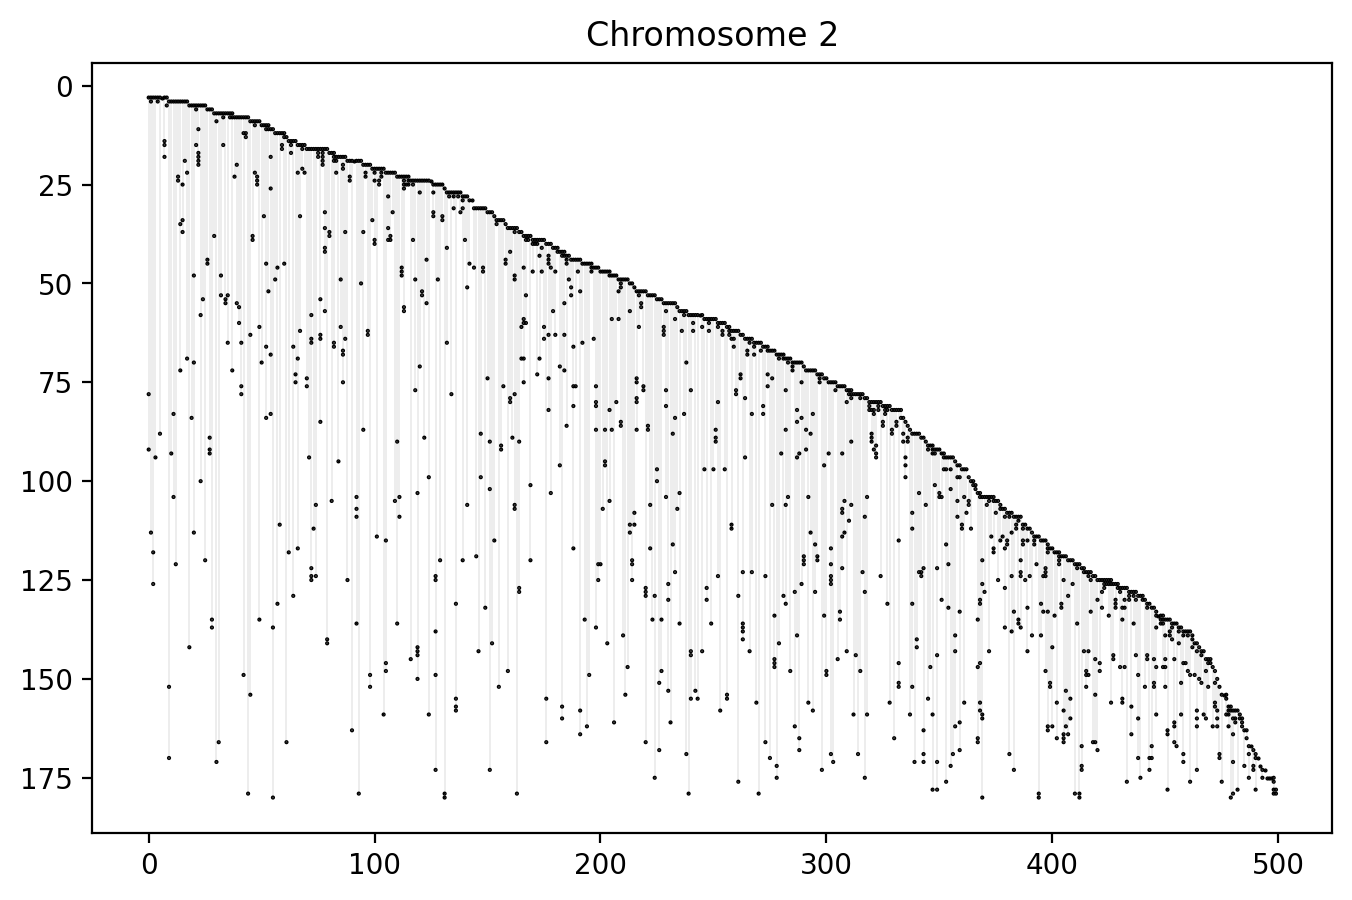

In [11]:
node_params = {
    's' : 1,
    'ec' : 'k',
    'lw' : 1,
    'marker' : ".",
    'zorder' : 2,
}

line_params = {
    'lw' : 0.1,
    'alpha' : 0.5,
    'zorder' : 1,
}

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 5

sample_size = 500
pdf = ut.sort_by_lowest_index(H.T.sample(sample_size).T)

plt2.plot_incidence(
    pdf, 
    node_color='k',
    node_params=node_params,
    line_params=line_params,
)

plt.title(f"Chromosome {chromosome}")

# Plot clique expansion

'outlier_indices=[3, 4, 5, 15, 23, 27, 29, 31, 32, 60, 77, 80, 84, 102, 104, 112, 113, 117, 125, 132, 155, 166, 167, 172, 180]'
A.shape=(149, 149)


Text(0.5, 302.6666666666665, '')

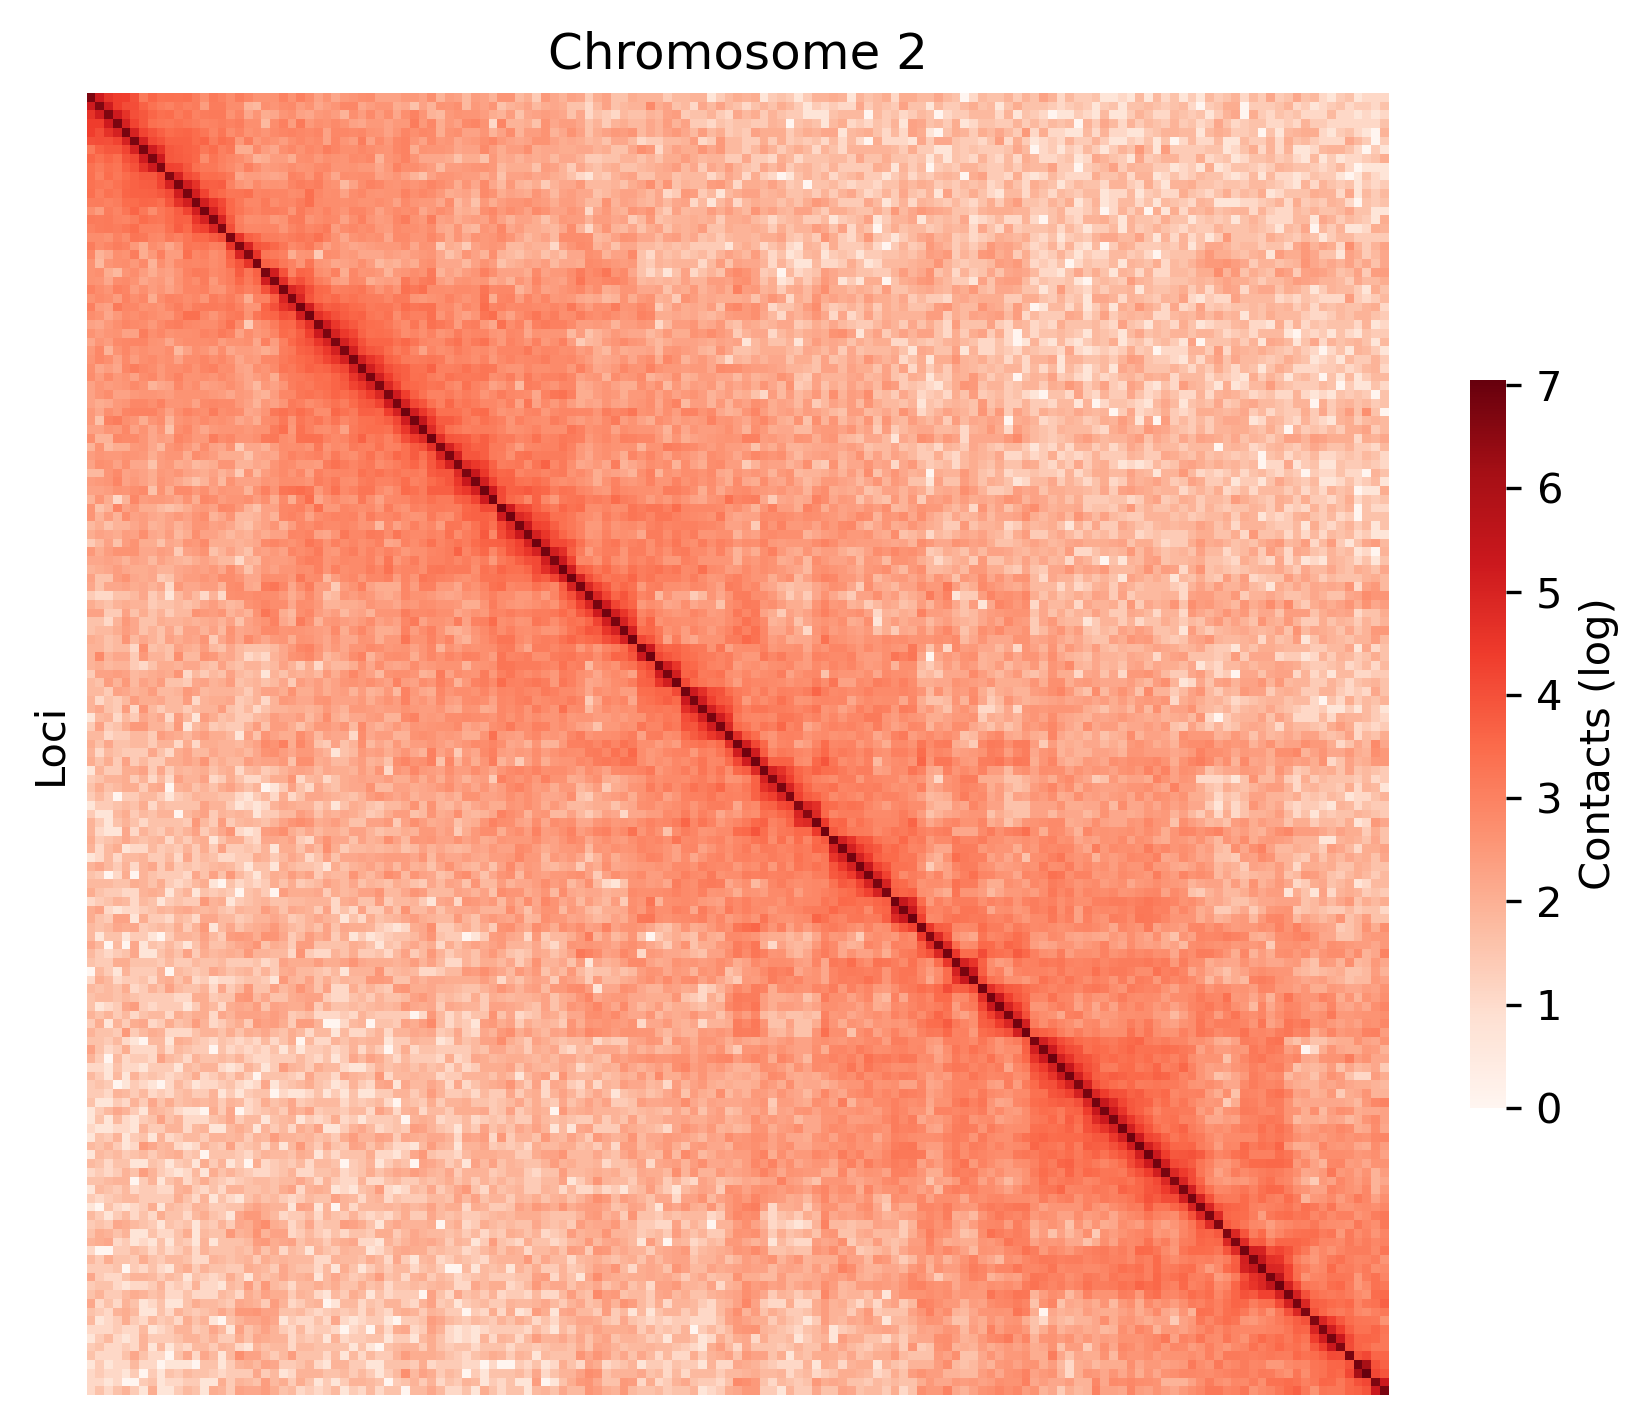

In [12]:
A = matrix.clique_expand_incidence(H, zero_diag=False) 
A = A.sort_index(axis=1)
A = A.sort_index(axis=0)

# find and report repeat regions
outlier_indices = matrix.find_outlier_row_indices(A, threshold=1.5)
print(f"'{outlier_indices=}'")

# drop outliers
A = A.drop(outlier_indices, axis=1)
A = A.drop(outlier_indices, axis=0)

print(f"{A.shape=}")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 7

sns.heatmap(
    np.log1p(A), 
    cmap='Reds',
    square=True, 
    cbar_kws={'shrink' : 0.45, 'label' : 'Contacts (log)'},
)

plt.yticks([])
plt.xticks([])

plt.title(f"Chromosome {chromosome}")
plt.ylabel(f"Loci")
plt.xlabel("")

# normalization

In [13]:
def balance_matrix(matrix, reg=0.25):
    """Balances a sparse matrix to be doubly stochastic using Sinkhorn-Knopp.

    Args:
        matrix: A scipy.sparse matrix.
        reg: Regularization parameter for Sinkhorn-Knopp algorithm.

    Returns:
        A balanced sparse matrix.
    """
    start_time = time.time()
    matrix = matrix.toarray()  # Convert to dense array for POT
    a = np.ones(matrix.shape[0]) / matrix.shape[0]  # Uniform row distribution
    b = np.ones(matrix.shape[1]) / matrix.shape[1]  # Uniform column distribution
    balanced_matrix = ot.sinkhorn(a, b, matrix, reg)  # Use input regularization parameter
    end_time = time.time()
    print(f"Balancing matrix took: {end_time - start_time:.2f} seconds")
    return csr_matrix(balanced_matrix)  # Convert back to sparse



def add_normalized_layers(cdata, target_sum=1):
    """A function to normalize bins and reads in two ways:
    1. Normalize each observation (row) to sum to target_sum.
    2. Normalize each variable (column) to sum to target_sum.
    """

    # Normalize by observation (rows)
    cdata.layers['obs_norm'] = cdata.X.copy() #create a copy to work on
    sc.pp.normalize_total(
        cdata,
        target_sum=target_sum,
        layer='obs_norm', #operate on the copy
        inplace=True #modify the layer directly
    )

    # Normalize by variable (columns)
    cdata.layers['var_norm'] = cdata.X.copy()
    cdata_T = an.AnnData(cdata.layers['var_norm'].T) #transpose to work on columns
    sc.pp.normalize_total(
        cdata_T,
        target_sum=target_sum,
        inplace=True
    )
    cdata.layers['var_norm'] = cdata_T.X.T #transpose back and assign to the layer

    return cdata
    
start_time = time.time()
cdata = add_normalized_layers(cdata, target_sum=1)
end_time = time.time()
print(f"Normalization took: {end_time - start_time:.2f} seconds")

cdata.layers['H_balanced'] = balance_matrix(cdata.layers['H'])

# set the layer
default_layer = 'H_binary'
cdata.X = cdata.layers[default_layer].copy()
sc.logging.print_memory_usage()
cdata

Normalization took: 0.03 seconds
Balancing matrix took: 0.46 seconds
Memory usage: current 1.78 GB, difference +0.29 GB


AnnData object with n_obs × n_vars = 174 × 51553
    obs: 'bin_index', 'chrom', 'bin_start', 'bin_end', 'bin', 'chrom_bin', 'n_reads', 'n_genes', 'n_tfs', 'n_pt_genes', 'total_gene_bp', 'genes', 'total_len_bp', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'degree', 'degree_outlier'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'higher_order', 'chrom_order'
    uns: 'base_resolution', 'chrom_sizes', 'genes', 'intervals'
    layers: 'H', 'H_binary', 'obs_norm', 'var_norm', 'H_balanced'

# compute centralities

In [14]:
layer_key = "H_binary"

# add the principal singular value of the incidence matrix
svd = TruncatedSVD(n_components=1, n_iter=10)
cdata.obs['singular_value_1'] = ut.min_max(svd.fit_transform(cdata.layers[layer_key]))

# add degree centrality
cdata.obs['degree_centrality'] = ut.min_max(cdata.layers[layer_key].sum(axis=1))

# hypergraph centralities
functions = [
    "linear", "log-exp", "max"
]

for func in functions:
    start_time = time.time()  # Record start time

    node, edge = central.nonlinear_eigenvector_centrality(
        cdata.layers[layer_key],
        function=func,
        maxiter=1000,
    )

    col_name = f"{func}_hge_centrality"
    cdata.obs[col_name] = ut.min_max(node)
    cdata.var[col_name] = ut.min_max(edge)

    end_time = time.time()  # Record end time
    print(f"{func}_centrality calculation took: {end_time - start_time:.2f} seconds")

sc.logging.print_memory_usage()
cdata

linear_centrality calculation took: 0.63 seconds
log-exp_centrality calculation took: 0.20 seconds
max_centrality calculation took: 0.17 seconds
Memory usage: current 1.78 GB, difference +0.00 GB


AnnData object with n_obs × n_vars = 174 × 51553
    obs: 'bin_index', 'chrom', 'bin_start', 'bin_end', 'bin', 'chrom_bin', 'n_reads', 'n_genes', 'n_tfs', 'n_pt_genes', 'total_gene_bp', 'genes', 'total_len_bp', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'degree', 'degree_outlier', 'singular_value_1', 'degree_centrality', 'linear_hge_centrality', 'log-exp_hge_centrality', 'max_hge_centrality'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'higher_order', 'chrom_order', 'linear_hge_centrality', 'log-exp_hge_centrality', 'max_hge_centrality'
    uns: 'base_resolution', 'chrom_sizes', 'genes', 'intervals'
    layers: 'H', 'H_binary', 'obs_norm', 'var_norm', 'H_balanced'

# visualize

degree_centrality


Tue Dec 17 12:27:23 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Tue Dec 17 12:27:23 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


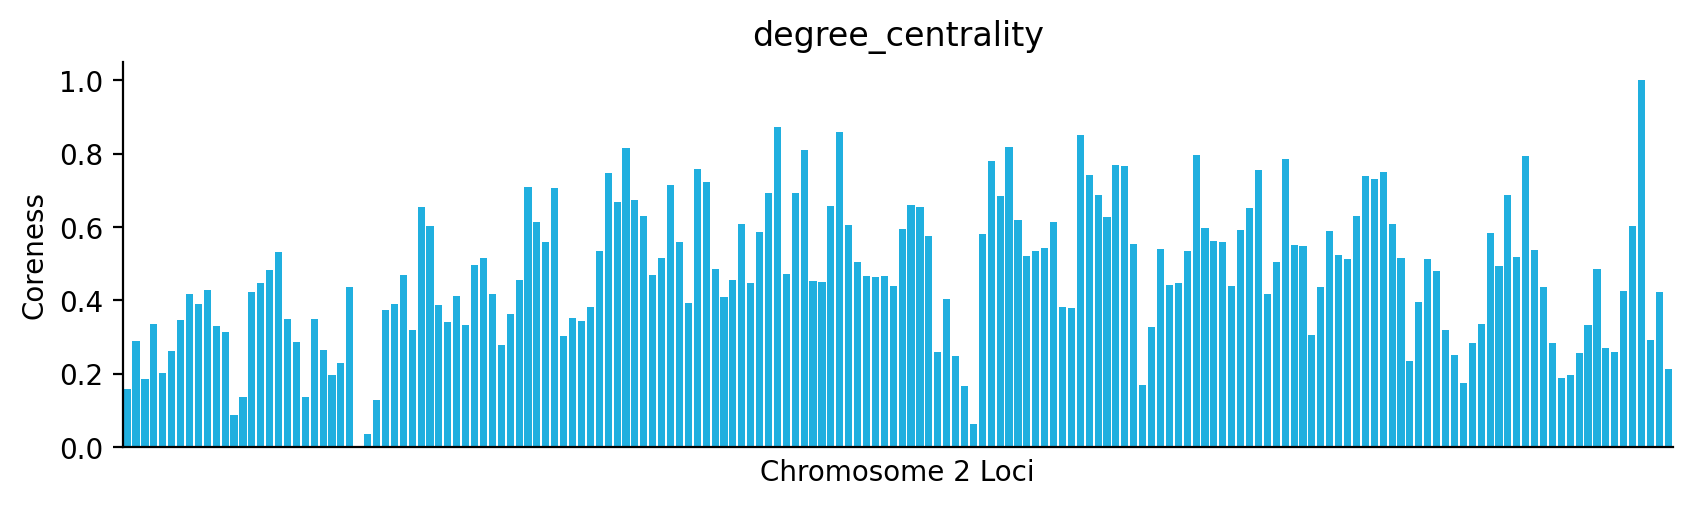

Tue Dec 17 12:27:24 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Tue Dec 17 12:27:24 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


singular_value_1


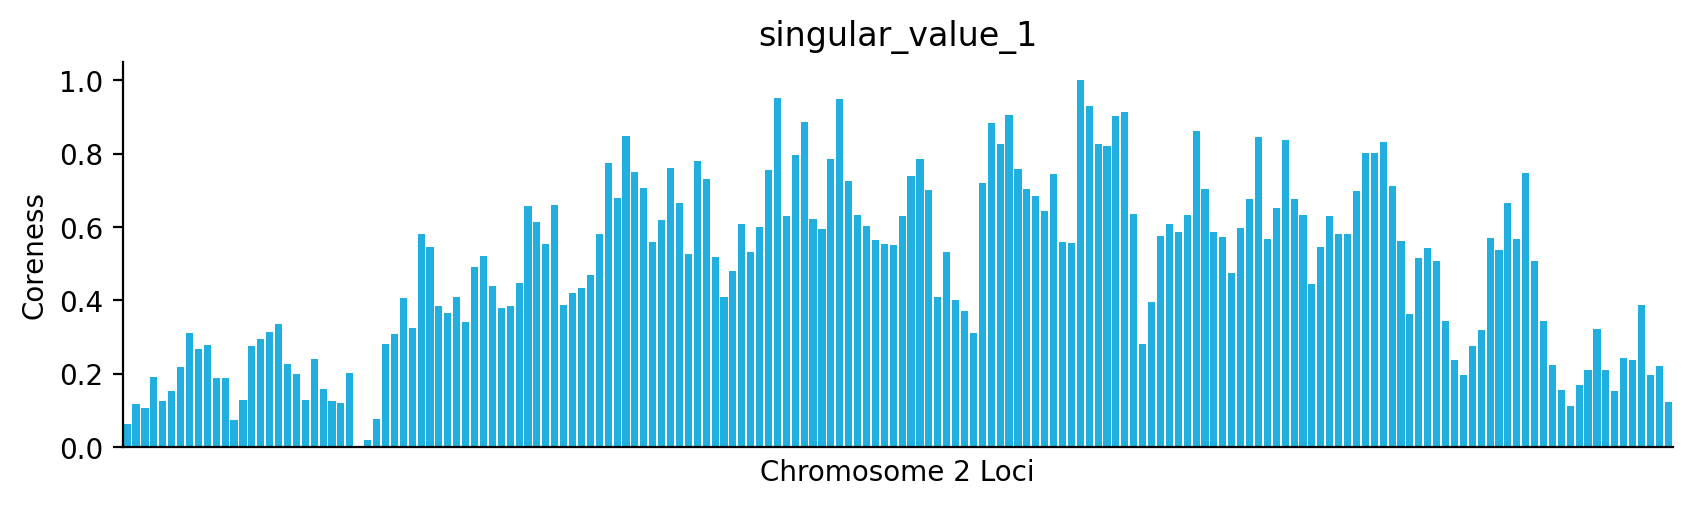

Tue Dec 17 12:27:24 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Tue Dec 17 12:27:24 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


linear_hge_centrality


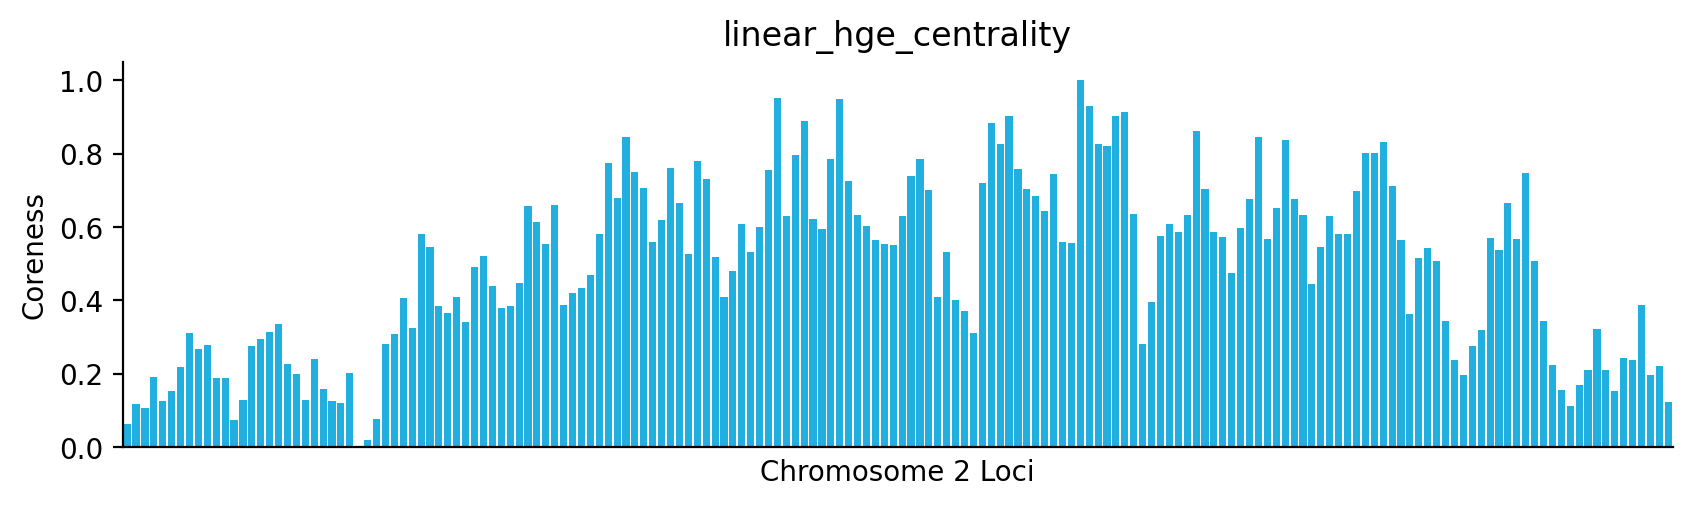

Tue Dec 17 12:27:25 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Tue Dec 17 12:27:25 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


log-exp_hge_centrality


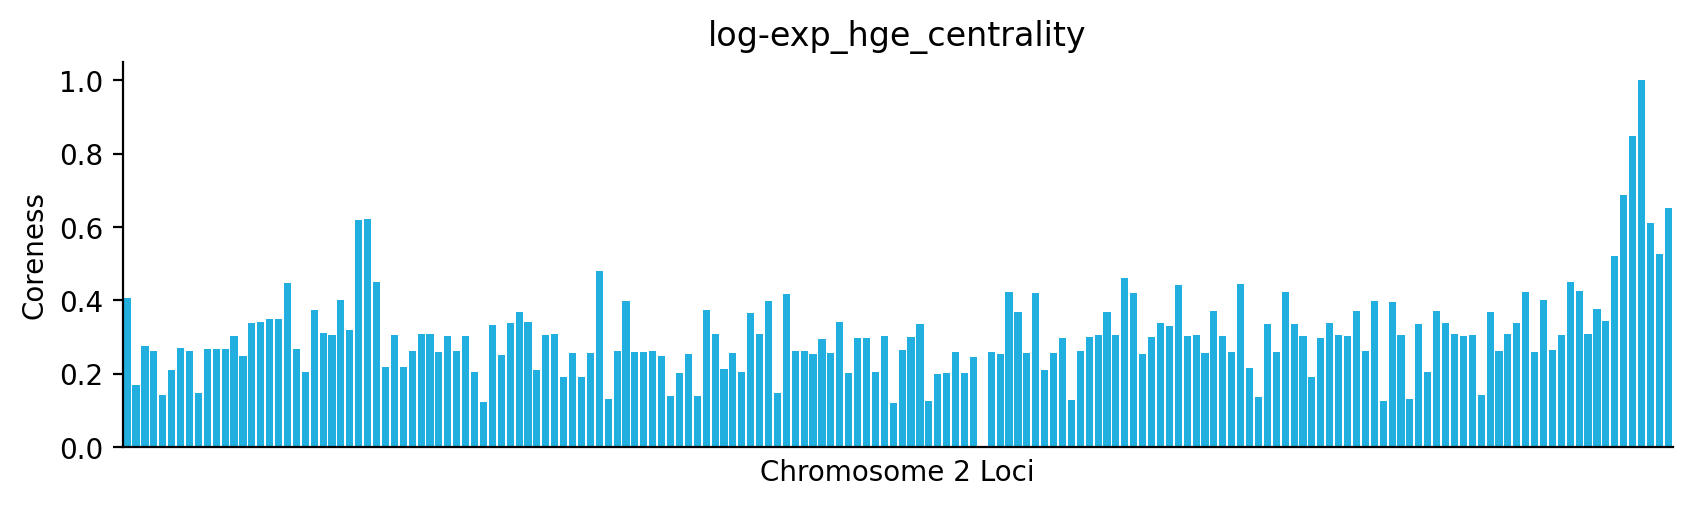

Tue Dec 17 12:27:25 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Tue Dec 17 12:27:25 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


max_hge_centrality


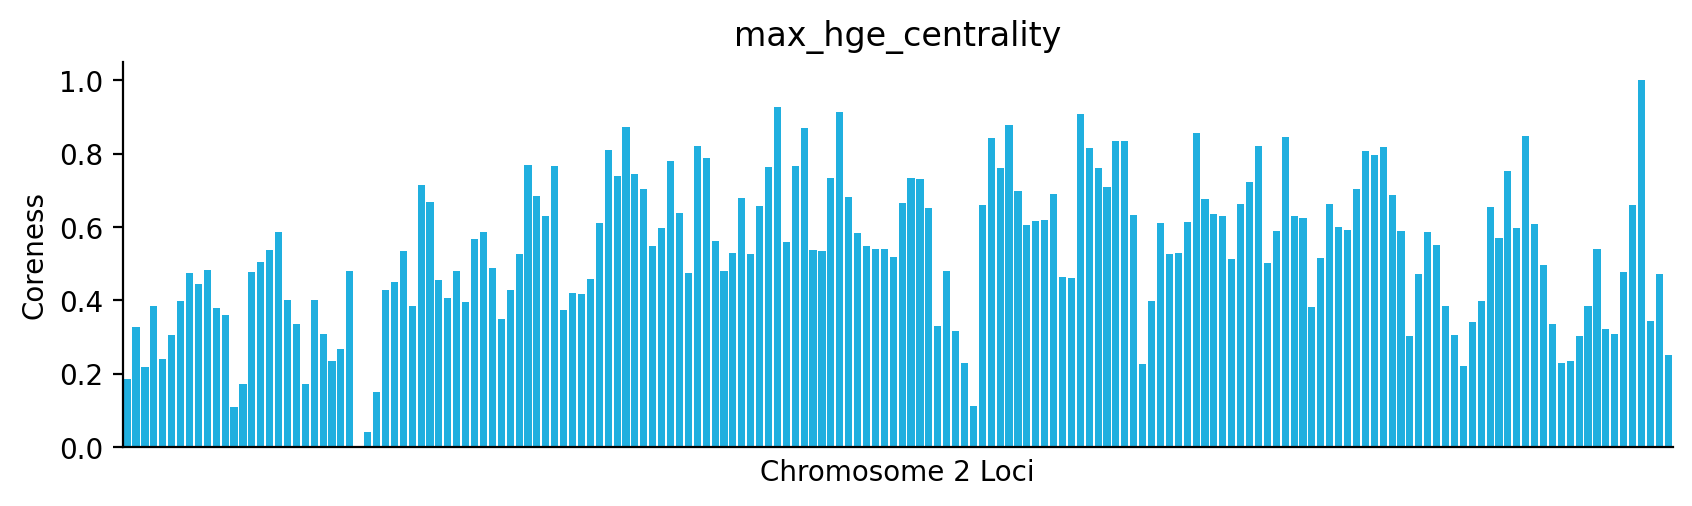

In [15]:
pdf = cdata.obs.copy()
pdf = pdf.sort_values(by='chrom_bin')


columns = [
    'degree_centrality',
    'singular_value_1',
    'linear_hge_centrality', 
    'log-exp_hge_centrality',
    'max_hge_centrality'
]


for centrality in columns:
    print(centrality)
    
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 10, 2.5

    x = pdf['chrom_bin']
    # y = scipy.stats.zscore(pdf[centrality])
    y = pdf[centrality]
    
    sns.barplot(
        x=x, y=y,
        color='deepskyblue',
        lw=0.25,
    )
    sns.despine()
    plt.title(centrality)
    plt.xlabel(f"Chromosome {chromosome} Loci")
    plt.ylabel(f"Coreness")
    plt.xticks([])

    plt.show()

# Who are the most central nodes?

In [16]:
cdata.obs.columns

Index(['bin_index', 'chrom', 'bin_start', 'bin_end', 'bin', 'chrom_bin',
       'n_reads', 'n_genes', 'n_tfs', 'n_pt_genes', 'total_gene_bp', 'genes',
       'total_len_bp', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF',
       'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5',
       'RNA_6', 'degree', 'degree_outlier', 'singular_value_1',
       'degree_centrality', 'linear_hge_centrality', 'log-exp_hge_centrality',
       'max_hge_centrality'],
      dtype='object')

In [17]:
column = "singular_value_1"
pdf = cdata.obs.copy()
pdf = pdf.sort_values(by=column, ascending=False,)

columns = [
    'chrom_bin', 
    'n_genes',
    'n_tfs',
] + [column]


pdf[columns].head()

,chrom_bin,n_genes,n_tfs,singular_value_1
bin_name,,,,
chr2:112,112,16,0,1.000000
chr2:77,77,13,0,0.950923
chr2:84,84,39,0,0.949510
chr2:113,113,20,0,0.929257
chr2:117,117,16,0,0.913105


In [18]:
top_bins = 10
gdf = cdata.uns['genes']
gdf = gdf[gdf['bin_name'].isin(pdf.head(top_bins).index)]

gdf = gdf[gdf['gene_biotype'] == 'protein_coding']
gdf = gdf[~gdf['gene_name'].str.startswith('Gm')]

print(f"{gdf.shape=}")

gdf

gdf.shape=(91, 14)


,gene_name,gene_id,gene_biotype,chrom,gene_length,is_tf,gene_start,gene_end,bin,bin_name,chrom_bin,overlap,n_bins_spanned,is_pt_gene
4207,Slc12a1,ENSMUSG00000027202,protein_coding,2,77498,False,125000000,126000000,321,chr2:125,125,71922,2,True
4208,Dut,ENSMUSG00000027203,protein_coding,2,11419,False,125000000,126000000,321,chr2:125,125,11419,1,True
4212,Eid1,ENSMUSG00000091337,protein_coding,2,1691,False,125000000,126000000,321,chr2:125,125,1691,1,True
4374,Pamr1,ENSMUSG00000027188,protein_coding,2,93030,False,102000000,103000000,298,chr2:102,102,93030,1,True
4380,Slc1a2,ENSMUSG00000005089,protein_coding,2,132126,False,102000000,103000000,298,chr2:102,102,132126,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7466,Arhgap11a,ENSMUSG00000041219,protein_coding,2,17170,False,113000000,114000000,309,chr2:113,113,17170,1,True
7470,Rasgrp1,ENSMUSG00000027347,protein_coding,2,63009,False,117000000,118000000,313,chr2:117,117,63009,1,True
7486,Secisbp2l,ENSMUSG00000035093,protein_coding,2,45885,False,125000000,126000000,321,chr2:125,125,45885,1,True
7487,Cops2,ENSMUSG00000027206,protein_coding,2,28836,False,125000000,126000000,321,chr2:125,125,28836,1,True


In [19]:
edf = gget.enrichr(gdf['gene_name'].to_list(), database='celltypes')
edf.head(15)

Tue Dec 17 12:27:26 2024 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database
0,1,Loop Of Henle Cells,0.000004,12.055488,149.305459,"[CALCRL, FRZB, SLC12A1, APLNR, SERPING1, PAMR1...",0.000385,PanglaoDB_Augmented_2021
1,2,Pericytes,0.000644,7.841667,57.614432,"[FRZB, APLNR, SERPING1, PAMR1, FBN1]",0.029642,PanglaoDB_Augmented_2021
2,3,Hepatic Stellate Cells,0.002871,7.273162,42.571511,"[WT1, FRZB, PAMR1, FBN1]",0.064680,PanglaoDB_Augmented_2021
3,4,Fibroblasts,0.003789,5.161527,28.778309,"[GREM1, FRZB, PAMR1, CD44, FBN1]",0.064680,PanglaoDB_Augmented_2021
4,5,Mast Cells,0.004001,5.093427,28.121317,"[SPRED1, CALCRL, APLNR, SERPING1, CCDC141]",0.064680,PanglaoDB_Augmented_2021
5,6,M?ller Cells,0.004218,6.505306,35.573168,"[FRZB, APLNR, PAMR1, CD44]",0.064680,PanglaoDB_Augmented_2021
6,7,Podocytes,0.009226,5.158431,24.171185,"[NCKAP1, WT1, CTNND1, EMC7]",0.096355,PanglaoDB_Augmented_2021
7,8,Pulmonary Vascular Smooth Muscle Cells,0.009825,7.200218,33.285653,"[SERPING1, PAMR1, FBN1]",0.096355,PanglaoDB_Augmented_2021
8,9,Vascular Smooth Muscle Cells,0.010938,6.910814,31.206001,"[WT1, PAMR1, FBN1]",0.096355,PanglaoDB_Augmented_2021
9,10,Juxtaglomerular Cells,0.010938,6.910814,31.206001,"[FRZB, SERPING1, PAMR1]",0.096355,PanglaoDB_Augmented_2021


In [20]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Clique-expand

In [ ]:
reload(matrix)

cdata.obsm['A'] = np.dot(cdata.layers[layer_key], cdata.layers[layer_key].T)
print(f"{cdata.obsm['A'].shape=}")

cdata.obsm['A_kr'] = matrix.normalize_kr(cdata.obsm['A'].todense())
print(f"{cdata.obsm['A_kr'].shape=}")

cdata.obsm['A_oe'] = csr_matrix(matrix.normalize_oe(cdata.obsm['A_kr'].todense()))
print(f"{cdata.obsm['A_oe'].shape=}")

cdata

# compute the PC1 of the clique-expanded matrix

In [ ]:
# add the principal singular value of the incidence matrix
svd = TruncatedSVD(n_components=1, n_iter=7)

ce_centralities = []

for A_layer in ['A', 'A_oe']:
    A = cdata.obsm[A_layer]
    print(f"{A_layer} {A.shape=} {type(A)=}")
    col_name = f'PC1_{A_layer}'
    ce_centralities.append(col_name)
    cdata.obs[col_name] = svd.fit_transform(cdata.obsm[A_layer])

cdata

In [ ]:
ce_centralities

In [ ]:
centralities = [
    'degree',
    'singular_value_1', 
    'linear_hg_centrality', 
    'log-exp_hg_centrality', 
    'max_hg_centrality',
    'PC1_A',
    'PC1_A_oe',
]

corr = cdata.obs[centralities].corr()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

sns.heatmap(
    corr, 
    square=True,
    lw=1,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",  # Format the annotations to show 2 decimal places
    cbar_kws={'shrink' : 0.3}
)

# Features

In [ ]:
feature_columns = [
    'n_genes', 'n_tfs', 'n_pt_genes', # gene-related
    'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 
    'CTCF', 'H3K27ac', 'H3K27me3', 
    'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6',
]

corr = cdata.obs[feature_columns].corr()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 12, 12

sns.heatmap(
    corr, 
    square=True,
    lw=1,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",  # Format the annotations to show 2 decimal places
    cbar_kws={'shrink' : 0.3}
)

In [ ]:
corr = cdata.obs[feature_columns + centralities].corr()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 25, 25

sns.heatmap(
    corr, 
    square=True,
    lw=1,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",  # Format the annotations to show 2 decimal places
    cbar_kws={'shrink' : 0.3}
)

In [ ]:
break

# Plot genes

In [ ]:
pdf = cdata.obs.copy()
pdf = pdf.sort_values(by='chrom_bin')

columns = ['n_genes', 'n_pt_genes', 'n_tfs']
colors = ['grey', 'green', 'red']

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 3

for i, column in enumerate(columns):

    x = pdf['chrom_bin']
    y = pdf[column]
    
    sns.lineplot(
        x=x, y=y,
        color=colors[i],
        lw=0.25,
        label=column,
    )
    
    # Fill the area under the curve
    plt.fill_between(
        x, y,
        color=colors[i],
        alpha=0.2,
    )

In [ ]:
break

In [ ]:
pdf = cdata.obs.copy()
pdf = pdf.sort_values(by='chrom_bin')

for centrality in centralities:
    print(centrality)
    
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 10, 3

    x = pdf['chrom_bin']
    y = scipy.stats.zscore(pdf[centrality])
    
    sns.lineplot(
        x=x, y=y,
        color='deepskyblue',
        lw=0.25,
    )

    # Fill the area under the curve
    plt.fill_between(
        x, y,
        color='deepskyblue',
        alpha=0.2,
    )

    plt.title(centrality)

    plt.show()

In [ ]:
break

# Clustering

In [ ]:
sc.pp.pca(
    cdata, 
    n_comps=50,
    zero_center=False,
    layer=layer_key,
)

cdata.obs['principal_component_1'] = cdata.obsm['X_pca'][:, 0]
cdata.obs['principal_component_2'] = cdata.obsm['X_pca'][:, 1]

sc.pl.pca_variance_ratio(cdata)
sc.pp.neighbors(cdata)
sc.tl.leiden(cdata, resolution=1)
sc.tl.umap(cdata)

sc.pl.umap(cdata, color=[
    'leiden',
    'bin_start',
    'log_n_genes',
    'log_n_tfs',
    
], ncols=2)

cdata

In [ ]:
sc.pl.umap(cdata, color=[
    'log_n_genes',
    'linear_hg_centrality', 
], ncols=2)

cdata

In [ ]:
cdata.obs[[
    'singular_value_centrality', 
    'linear_hg_centrality', 
    'log-exp_hg_centrality', 
    'max_hg_centrality',
]].corr()

# Plot centralities

In [ ]:
cdata.obs.head()

In [ ]:
pdf = cdata.obs.copy()
pdf = pdf.sort_values(by='chrom_bin')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 3

sns.lineplot(
    data=pdf,
    x='chrom_bin',
    y='n_genes',
    color='grey',
    lw=0.25,
)

# Fill the area under the curve
plt.fill_between(
    pdf['chrom_bin'],
    pdf['n_genes'],
    color='grey',
    alpha=0.2,
)

sns.lineplot(
    data=pdf,
    x='chrom_bin',
    y='n_pt_genes',
    color='green',
    lw=0.25,
)

# Fill the area under the curve
plt.fill_between(
    pdf['chrom_bin'],
    pdf['n_pt_genes'],
    color='green',
    alpha=0.2,
)

sns.lineplot(
    data=pdf,
    x='chrom_bin',
    y='n_tfs',
    color='r',
    lw=0.25,
)

# Fill the area under the curve
plt.fill_between(
    pdf['chrom_bin'],
    pdf['n_tfs'],
    color='r',
    alpha=0.2,
)

# plt.ylim([0, 15])
# plt.xticks([])
# plt.yscale('log')

In [ ]:
break

In [ ]:
cdata.obs.columns

In [ ]:
pdf = cdata.obs.copy()
pdf = pdf.sort_values(by='chrom_bin')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 3

sns.lineplot(
    data=pdf,
    x='chrom_bin',
    y='singular_value_centrality',
    color='C0',
    lw=0.25,
)

# Fill the area under the curve
plt.fill_between(
    pdf['chrom_bin'],
    pdf['singular_value_centrality'],
    color='C0',
    alpha=0.2,
)

# plt.xticks([])
# plt.yscale('log')

In [ ]:
cdata.obs.column

In [ ]:
cdata.uns['genes']['gene_biotype'].value_counts()

In [ ]:
break

# Clique Expansion

In [ ]:
reload(matrix)

adata.obsm['A'] = np.dot(adata.X, adata.X.T)
print(type(adata.obsm['A']))
print(adata.obsm['A'].shape)

adata

In [ ]:
break

In [ ]:
break

# Degree Centrality

In [ ]:
pdf = adata.obs.copy()
pdf['n_reads'] = pdf['n_reads'].astype(int)
sns.histplot(
    data=pdf,
    x='n_reads',
    log_scale=True,
)

In [ ]:
pdf = adata.obs.copy()
pdf = pdf.sort_values(by='bin')
print(f"{pdf.shape=}")

pdf['bin'] = pdf['bin'].astype(int)
pdf['n_reads'] = pdf['n_reads'].astype(int)
pdf['n_reads_log'] = np.log1p(pdf['n_reads'])

plt.rcParams['figure.figsize'] = 10, 5

sns.barplot(
    data=pdf,
    x='bin',
    y='n_reads_log',
    hue='chrom',
    legend=False,
    palette='tab20b',
    ec='none',
    width=0.4,
)

plt.xticks([])
pdf.head()


In [ ]:
pdf.head(15)

In [ ]:
break

In [ ]:
result = []

for chrom, group in adata.obs.groupby('chrom'):
    chrom_data = adata[group.index,]
    chrom_data = chrom_data[:, chrom_data.X.sum(axis=0) > 1]
    
    row = {
        'chrom' : chrom,
        'n_bins' : chrom_data.shape[0],
        'n_reads' : chrom_data.shape[1],
        'mean_order' : chrom_data.var['order'].mean(),
        'median_order' : chrom_data.var['order'].median(),
        'chrom_connectivity' : chrom_data.var['n_chromosomes'].mean(),
    }
    result.append(row)
    # break

result = pd.DataFrame(result)
result.head()

In [ ]:
sns.barplot(
    data=result,
    x='chrom',
    y='mean_order',
)

# highest degree centrality

In [ ]:
def flatten_list(nested_list):
  flat_list = []
  for sublist in nested_list:
    for item in sublist.split(';'):
      flat_list.append(item)
  return flat_list

In [ ]:
n_nodes = 50
df = adata.obs.copy()
df = df.sort_values(by='n_reads', ascending=False)

df = df.head(n_nodes)
genes = flatten_list(df['genes'].values)
print(f"Total Genes: {len(genes)}")
genes = [x for x in genes if not x.startswith('Gm')] # exclude the predicted genes
genes = [x for x in genes if not x.endswith('Rik')] # exclude the Rik genes
genes = [x for x in genes if not "-" in x] # exclude the predicted genes
print(f"Filtered Genes: {len(genes)}")
genes[:10]

In [ ]:
database = 'ontology'
edf = gget.enrichr(genes, database=database)
edf.head(25)

In [ ]:
edf['path_name'].head(25).values

In [ ]:
break

In [ ]:
adata.var.head()

In [ ]:
break

# centrality

In [ ]:
# add the principal singular value of the incidence matrix
svd = TruncatedSVD(n_components=1, n_iter=7)
adata.obs['singular_value_centrality'] = svd.fit_transform(adata.X)
adata

# Hypergraph Centrality

In [ ]:
functions = [
    "linear", "log-exp", "max"
]

for func in functions:
    start_time = time.time()  # Record start time

    node, edge = central.nonlinear_eigenvector_centrality(
        adata.X,
        function=func,
        maxiter=1000,
    )

    col_name = f"{func}_hg_centrality"
    adata.obs[col_name] = node
    adata.var[col_name] = edge

    end_time = time.time()  # Record end time
    print(f"{func}_centrality calculation took: {end_time - start_time:.2f} seconds")

adata

# Clique expansion

In [ ]:
reload(matrix)

adata.obsm['A'] = np.dot(adata.X, adata.X.T)
print(type(adata.obsm['A']))
print(adata.obsm['A'].shape)

adata

# visualize

In [ ]:
chr_idx = adata.obs['chrom'] == '2'
A = adata.obsm['A'][chr_idx, :][:, chr_idx][3:, 3:]
A = np.log1p(A.todense())
plt.imshow(A)

In [ ]:
chr2 = adata[adata.obs['chrom'] == '2', :]

chr2.obsm['A'].shape

In [ ]:
# break

# Graph centralities

In [ ]:
def compute_centrality_measures(adata, obsm_key='ce'):
  """
  Computes and adds various centrality measures to an AnnData object.

  Args:
    adata: An AnnData object.
    G: A NetworkX graph object.
    obsm_key: The obsm string for the matrix to use during graph construction

  Returns:
    The modified AnnData object with added centrality measures.
  """
  print(f"Using obsm key: {obsm_key}")
  A = adata.obsm[obsm_key]
  print(f"{A.shape=} {type(A)}")
  G = nx.from_scipy_sparse_array(A)

  print("\tComputing degree centrality...")
  adata.obs[f'degree_centrality_{obsm_key}'] = nx.degree_centrality(G).values()

  print("\tComputing eigenvector centrality...")
  adata.obs[f'eigenvector_centrality_{obsm_key}'] = nx.eigenvector_centrality(G).values()

  print("\tComputing closeness centrality...")
  adata.obs[f'closeness_centrality_{obsm_key}'] = nx.closeness_centrality(G).values()
  return adata

adata = compute_centrality_measures(adata, obsm_key='A')

adata

In [ ]:
nan_count = np.isnan(adata.obsm['A_oe'].data).sum()
nan_count / adata.obsm['A_oe'].size

# Plot

In [ ]:
centrality_cols = [x for x in adata.obs.columns if 'centrality' in x]
corr = adata.obs[centrality_cols].corr()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 10

sns.heatmap(
    corr, 
    square=True,
    lw=1,
    cmap='coolwarm',
    annot=True,
    cbar_kws={'shrink' : 0.3}
)

# investigate

In [ ]:
df.columns

In [ ]:
for column in centrality_cols:
    df = adata.obs.copy()

    df = df.sort_values(by=column, ascending=False,)
    print(column)
    print(df[['chrom', 'n_genes', 'n_reads', 'n_tfs']].head())
    print()

    # break

In [ ]:
break

In [ ]:
sns.scatterplot(
    data=adata.obs,
    x='n_tfs',
    y='principal_singular_value',
    # showfliers=False,
)

In [ ]:
break

In [ ]:
sc.pl.umap(
    adata,
    color=['log_mean_expression']
)

# Compute global centralities

In [ ]:
functions = [
    "linear", "log-exp", "max"
]

def normalize_vector(vector):
  """
  Normalizes a vector to the range [0, 1] using MinMaxScaler.
  """
  vector = np.array(vector).reshape(-1, 1) 
  scaler = MinMaxScaler()
  normalized_vector = scaler.fit_transform(vector)
  return normalized_vector.flatten()


for func in functions:
    node, edge = central.nonlinear_eigenvector_centrality(
        adata.layers['H_norm'].copy(),
        function=func,
        maxiter=2,
    )

    col_name = f"{func}_centrality"
    adata.obs[col_name] = normalize_vector(node)
    adata.var[col_name] = normalize_vector(edge)

adata

In [ ]:
sc.pl.umap(
    adata,
    color=[
        'linear_centrality',
        'log-exp_centrality',
        'max_centrality',
    ]
)